# Download Credit Card Fraud Dataset

This cell downloads the credit card fraud dataset from Google Drive and saves it to the data folder.

## Dataset Information:
- Dataset: Credit Card Fraud Detection
- Source: Google Drive
- Description: Contains transactions made by credit cards in September 2013 by European cardholders
- Features: 28 anonymized features (V1-V28) plus Time and Amount
- Target: Binary classification (0: Normal, 1: Fraud)


In [ ]:
# Download dataset from Google Drive
import os
import gdown

def download_creditcard_dataset():
    """
    Download credit card fraud dataset from Google Drive and save to data folder
    """
    try:
        # Google Drive file ID (extracted from the URL)
        file_id = "1_Kg6ZiR3tTMC-nG4ut5F0lXdrdUHOoMC"
        
        # Check if dataset already exists
        data_dir = '../data'
        csv_file = os.path.join(data_dir, 'creditcard.csv')
        
        if os.path.exists(csv_file):
            print(f"✓ Dataset already exists at {csv_file}")
            return True
        
        # Create data directory if it doesn't exist
        os.makedirs(data_dir, exist_ok=True)
        
        # Download dataset from Google Drive
        print("Downloading credit card fraud dataset from Google Drive...")
        print(f"File ID: {file_id}")
        
        # Use gdown to download the file
        url = f"https://drive.google.com/uc?id={file_id}"
        output_path = os.path.join(data_dir, 'creditcard.csv')
        
        gdown.download(url, output_path, quiet=False)
        
        # Verify download
        if os.path.exists(output_path):
            print(f"Dataset downloaded successfully to {output_path}")
            
            # Get file info
            file_size = os.path.getsize(output_path) / (1024 * 1024)  # MB
            print(f"File size: {file_size:.2f} MB")
            
            return True
        else:
            print("Download failed - file not found")
            return False
            
    except Exception as e:
        print(f"Error downloading dataset: {str(e)}")
        return False

# Execute download
success = download_creditcard_dataset()

if success:
    print("\nDataset ready for preprocessing!")
else:
    print("\nPlease resolve the issues above before proceeding with preprocessing.")


# Comprehensive Data Preprocessing for Fraud Detection

This notebook implements complete data preprocessing pipeline with the following steps:

## Objectives:
1. **Dataset Exploration**: Comprehensive analysis of the Base.csv dataset
2. **Data Transformation**: Convert categorical data and scale continuous features
3. **Class Balancing**: Oversample minority class using SMOTE technique
4. **Data Splitting**: Create train/test splits and save as CSV files

In [ ]:
# Variables
file_path = '../data/creditcard.csv'
class_label = 'Class'
random_seed = 42
scaling_method = 'StandardScaler'
balancing_method = 'smote'
train_test_split_ratio = '80:20'
train_csv_path = f'../data/train.csv'
test_csv_path = f'../data/test.csv'
metadata_path = '../data/preprocessing_metadata.json'


In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.under_sampling import NearMiss, TomekLinks, RandomUnderSampler
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(random_seed)

print("All libraries imported successfully!")

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)


All libraries imported successfully!


## 1. Dataset Loading and Initial Exploration

Loading the Base.csv dataset and performing comprehensive exploratory data analysis.


In [ ]:
# Load the dataset
print("Loading Base.csv dataset...")
# df = pd.read_csv('../data/Base.csv')
df = pd.read_csv(file_path)

print(f"Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(f"Dataset size: {df.size:,} cells")

# Basic dataset information
print("\n=== Dataset Overview ===")
print(df.info())

Loading Base.csv dataset...
Dataset loaded successfully!
Dataset shape: (284807, 31)
Dataset size: 8,829,017 cells

=== Dataset Overview ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-nu

=== Class Distribution Analysis ===
Target variable: Class
Class counts:
Class
0    284315
1       492
Name: count, dtype: int64

Class percentages:
Class
0    99.827251
1     0.172749
Name: proportion, dtype: float64


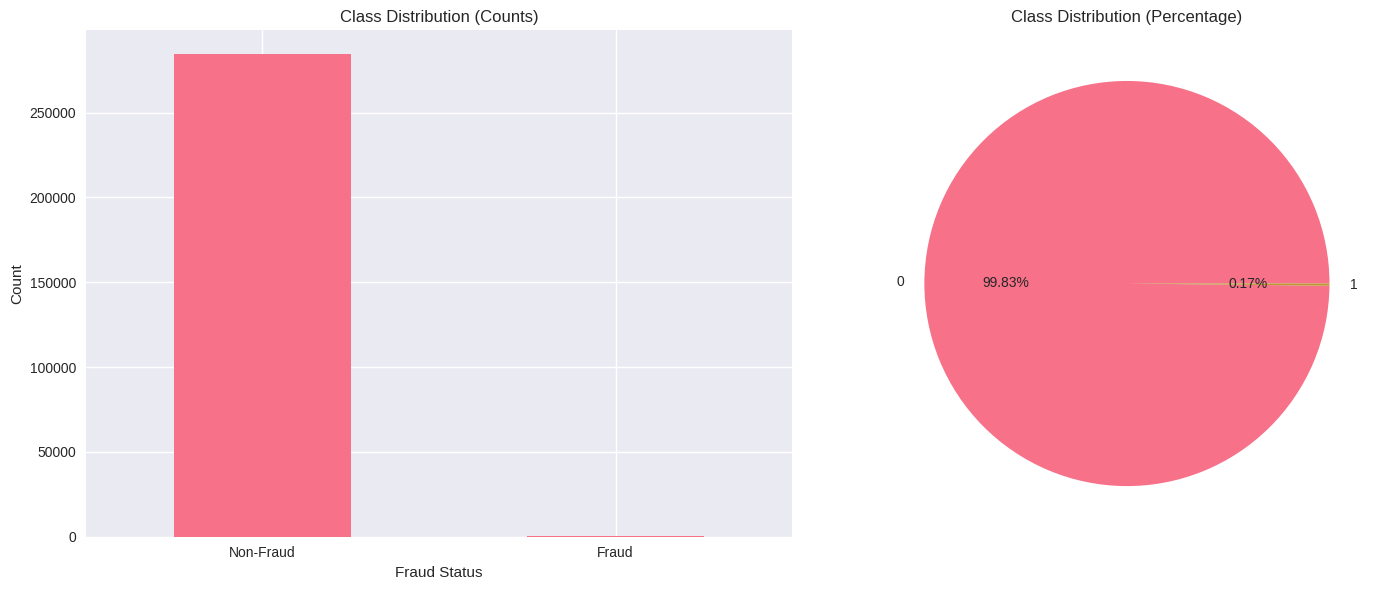


Imbalance ratio (Non-Fraud:Fraud): 577.88:1
Fraud percentage: 0.17%


In [ ]:
# Class distribution analysis
print("=== Class Distribution Analysis ===")
print(f"Target variable: {class_label}")
print(f"Class counts:")
print(df[class_label].value_counts())
print(f"\nClass percentages:")
print(df[class_label].value_counts(normalize=True) * 100)

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Count plot
df[class_label].value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_title('Class Distribution (Counts)')
axes[0].set_xlabel('Fraud Status')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Non-Fraud', 'Fraud'], rotation=0)

# Pie chart
df[class_label].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.2f%%')
axes[1].set_title('Class Distribution (Percentage)')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

# Calculate imbalance ratio
fraud_count = df[class_label].sum()
non_fraud_count = len(df) - fraud_count
imbalance_ratio = non_fraud_count / fraud_count
print(f"\nImbalance ratio (Non-Fraud:Fraud): {imbalance_ratio:.2f}:1")
print(f"Fraud percentage: {(fraud_count/len(df)*100):.2f}%")


## 3. Data Transformation: Categorical Encoding and Feature Scaling

Converting categorical variables to numerical format and scaling continuous features for optimal model performance.


In [ ]:
# Identify feature types for encoding and scaling
print("=== Feature Type Classification ===")

# Separate features and target
target_col = class_label
feature_cols = [col for col in df.columns if col != target_col]

# Classify features
categorical_features = []
numerical_features = []

numerical_features = [col for col in feature_cols if col not in categorical_features]

print(f"Categorical features ({len(categorical_features)}): {categorical_features}")
print(f"Numerical features ({len(numerical_features)}): {numerical_features}")

=== Feature Type Classification ===
Categorical features (0): []
Numerical features (30): ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


In [ ]:
# Scale numerical features
print("=== Feature Scaling ===")

df_scaled = df.copy()

# Separate features and target for scaling
X = df_scaled.drop(columns=[target_col])
X_categorical = df_scaled[categorical_features]
X_numerical = df_scaled[numerical_features]
y = df_scaled[target_col]


print(f"Features shape before scaling: {X_numerical.shape}")
print(f"Target shape: {y.shape}")

# Apply StandardScaler to all features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numerical)

# Convert back to DataFrame to maintain column names
X_numerical_scaled_df = pd.DataFrame(X_scaled, columns=X_numerical.columns, index=X_numerical.index)
X_scaled_df = pd.concat([X_numerical_scaled_df, X_categorical], axis=1)

print(f"Features shape after scaling: {X_scaled_df.shape}")

# Compare statistics before and after scaling
print("\n=== Scaling Results Comparison ===")
print("Before scaling (original features):")
print(X[numerical_features].describe())

print("\nAfter scaling (all features):")
print(X_scaled_df.describe())

# Verify scaling worked correctly
print(f"\n=== Scaling Verification ===")
print(f"Mean of scaled features (should be ~0): {X_scaled_df.mean().mean():.6f}")
print(f"Std of scaled features (should be ~1): {X_scaled_df.std().mean():.6f}")

# Create final processed dataset
df_final = X_scaled_df.copy()
df_final[target_col] = y

print(f"\n✅ Feature scaling completed successfully!")
print(f"Final dataset shape: {df_final.shape}")
print(f"Final dataset columns: {list(df_final.columns)}")


=== Feature Scaling ===
Features shape before scaling: (284807, 30)
Target shape: (284807,)
Features shape after scaling: (284807, 30)

=== Scaling Results Comparison ===
Before scaling (original features):
                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8           

## 4. Train-Test Split (Before Sampling)

**CRITICAL**: Split data first, then apply sampling techniques only to training data to prevent data leakage.


=== Original Dataset Analysis ===
Class counts:
Class
0    284315
1       492
Name: count, dtype: int64

Class percentages:
Class
0    99.827251
1     0.172749
Name: proportion, dtype: float64

Original imbalance ratio (Non-Fraud:Fraud): 577.88:1
Total samples: 284,807


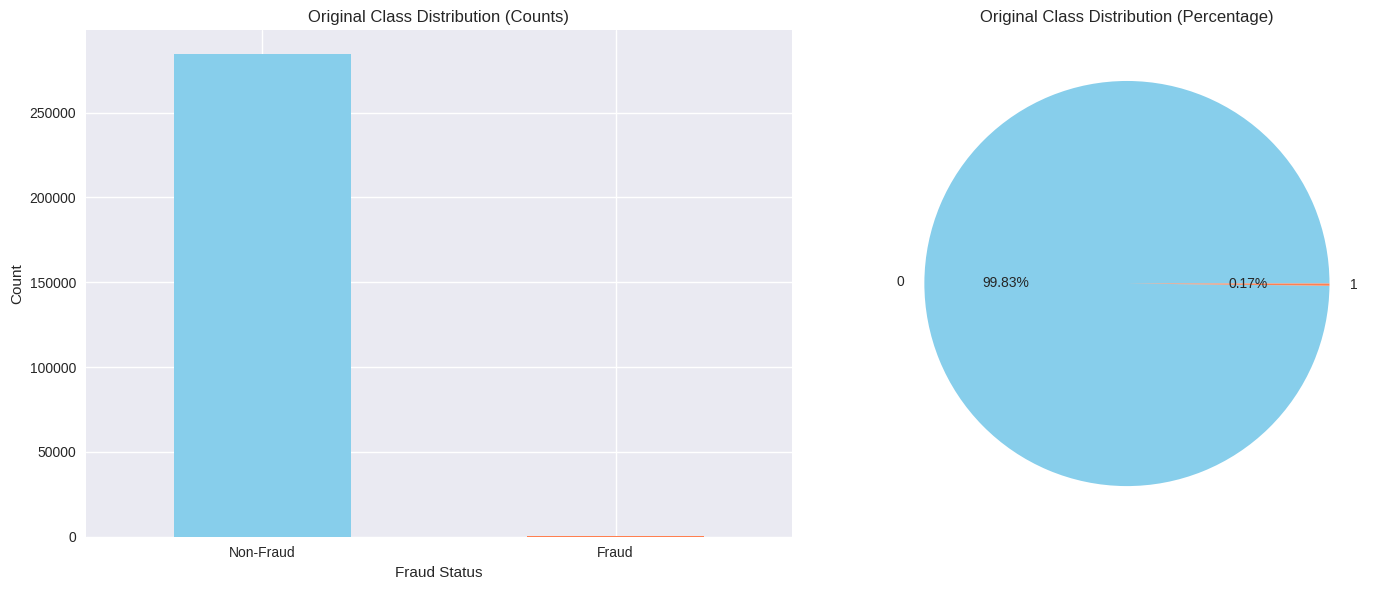


=== Train-Test Split Results ===
Training set: 256,326 samples (90.0%)
Test set: 28,481 samples (10.0%)

Class distribution in training set:
Class
0    255883
1       443
Name: count, dtype: int64
Training fraud percentage: 0.17%

Class distribution in test set:
Class
0    28432
1       49
Name: count, dtype: int64
Test fraud percentage: 0.17%

Training set imbalance ratio (Non-Fraud:Fraud): 577.61:1
Test set preserved in original imbalanced state for realistic evaluation


In [ ]:
# Step 1: Split the data into train/test BEFORE any sampling
print("=== Original Dataset Analysis ===")
print("Class counts:")
print(y.value_counts())
print("\nClass percentages:")
print(y.value_counts(normalize=True) * 100)

fraud_count_original = y.sum()
non_fraud_count_original = len(y) - fraud_count_original
imbalance_ratio_original = non_fraud_count_original / fraud_count_original

print(f"\nOriginal imbalance ratio (Non-Fraud:Fraud): {imbalance_ratio_original:.2f}:1")
print(f"Total samples: {len(y):,}")

# Visualize original class distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Count plot
y.value_counts().plot(kind='bar', ax=axes[0], color=['skyblue', 'coral'])
axes[0].set_title('Original Class Distribution (Counts)')
axes[0].set_xlabel('Fraud Status')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Non-Fraud', 'Fraud'], rotation=0)

# Pie chart
y.value_counts().plot(kind='pie', ax=axes[1], autopct='%1.2f%%', colors=['skyblue', 'coral'])
axes[1].set_title('Original Class Distribution (Percentage)')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

# Split the preprocessed data into train/test (80/20)
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_scaled_df, y, 
    test_size=0.1, 
    random_state=42, 
    stratify=y  # Maintain class distribution in both splits
)

print(f"\n=== Train-Test Split Results ===")
print(f"Training set: {X_train_raw.shape[0]:,} samples ({X_train_raw.shape[0]/len(X_scaled_df)*100:.1f}%)")
print(f"Test set: {X_test_raw.shape[0]:,} samples ({X_test_raw.shape[0]/len(X_scaled_df)*100:.1f}%)")

# Verify class distribution in splits
print(f"\nClass distribution in training set:")
print(y_train_raw.value_counts())
print(f"Training fraud percentage: {y_train_raw.mean()*100:.2f}%")

print(f"\nClass distribution in test set:")
print(y_test_raw.value_counts())
print(f"Test fraud percentage: {y_test_raw.mean()*100:.2f}%")

# Store original statistics for later comparison
fraud_count_train = y_train_raw.sum()
non_fraud_count_train = len(y_train_raw) - fraud_count_train
imbalance_ratio_train = non_fraud_count_train / fraud_count_train

print(f"\nTraining set imbalance ratio (Non-Fraud:Fraud): {imbalance_ratio_train:.2f}:1")
print(f"Test set preserved in original imbalanced state for realistic evaluation")


In [ ]:
## 5. Sampling Techniques Applied to Training Data Only

# Import additional libraries for SMOTE
from imblearn.over_sampling import SMOTE

sampler = SMOTE(
    sampling_strategy=0.6,  # 1:1 ratio
    random_state=random_seed,
    k_neighbors=5
)

X_train_combined, y_train_combined = sampler.fit_resample(X_train_raw, y_train_raw)

selected_technique = 'smote'

X_train_final = pd.DataFrame(X_train_combined, columns=X_train_raw.columns)
y_train_final = pd.Series(y_train_combined, name=target_col)

# Test data remains unchanged (original imbalanced distribution)
X_test_final = X_test_raw.copy()
y_test_final = y_test_raw.copy()

print(f"Training set (after {selected_technique}): {X_train_final.shape}")
print(f"Test set (original): {X_test_final.shape}")
print(f"Test set maintains realistic class imbalance for proper evaluation")


🎯 APPLYING SAMPLING TECHNIQUES TO TRAINING DATA ONLY

✅ Final dataset preparation completed!
Training set (after smote): (409412, 30)
Test set (original): (28481, 30)
Test set maintains realistic class imbalance for proper evaluation


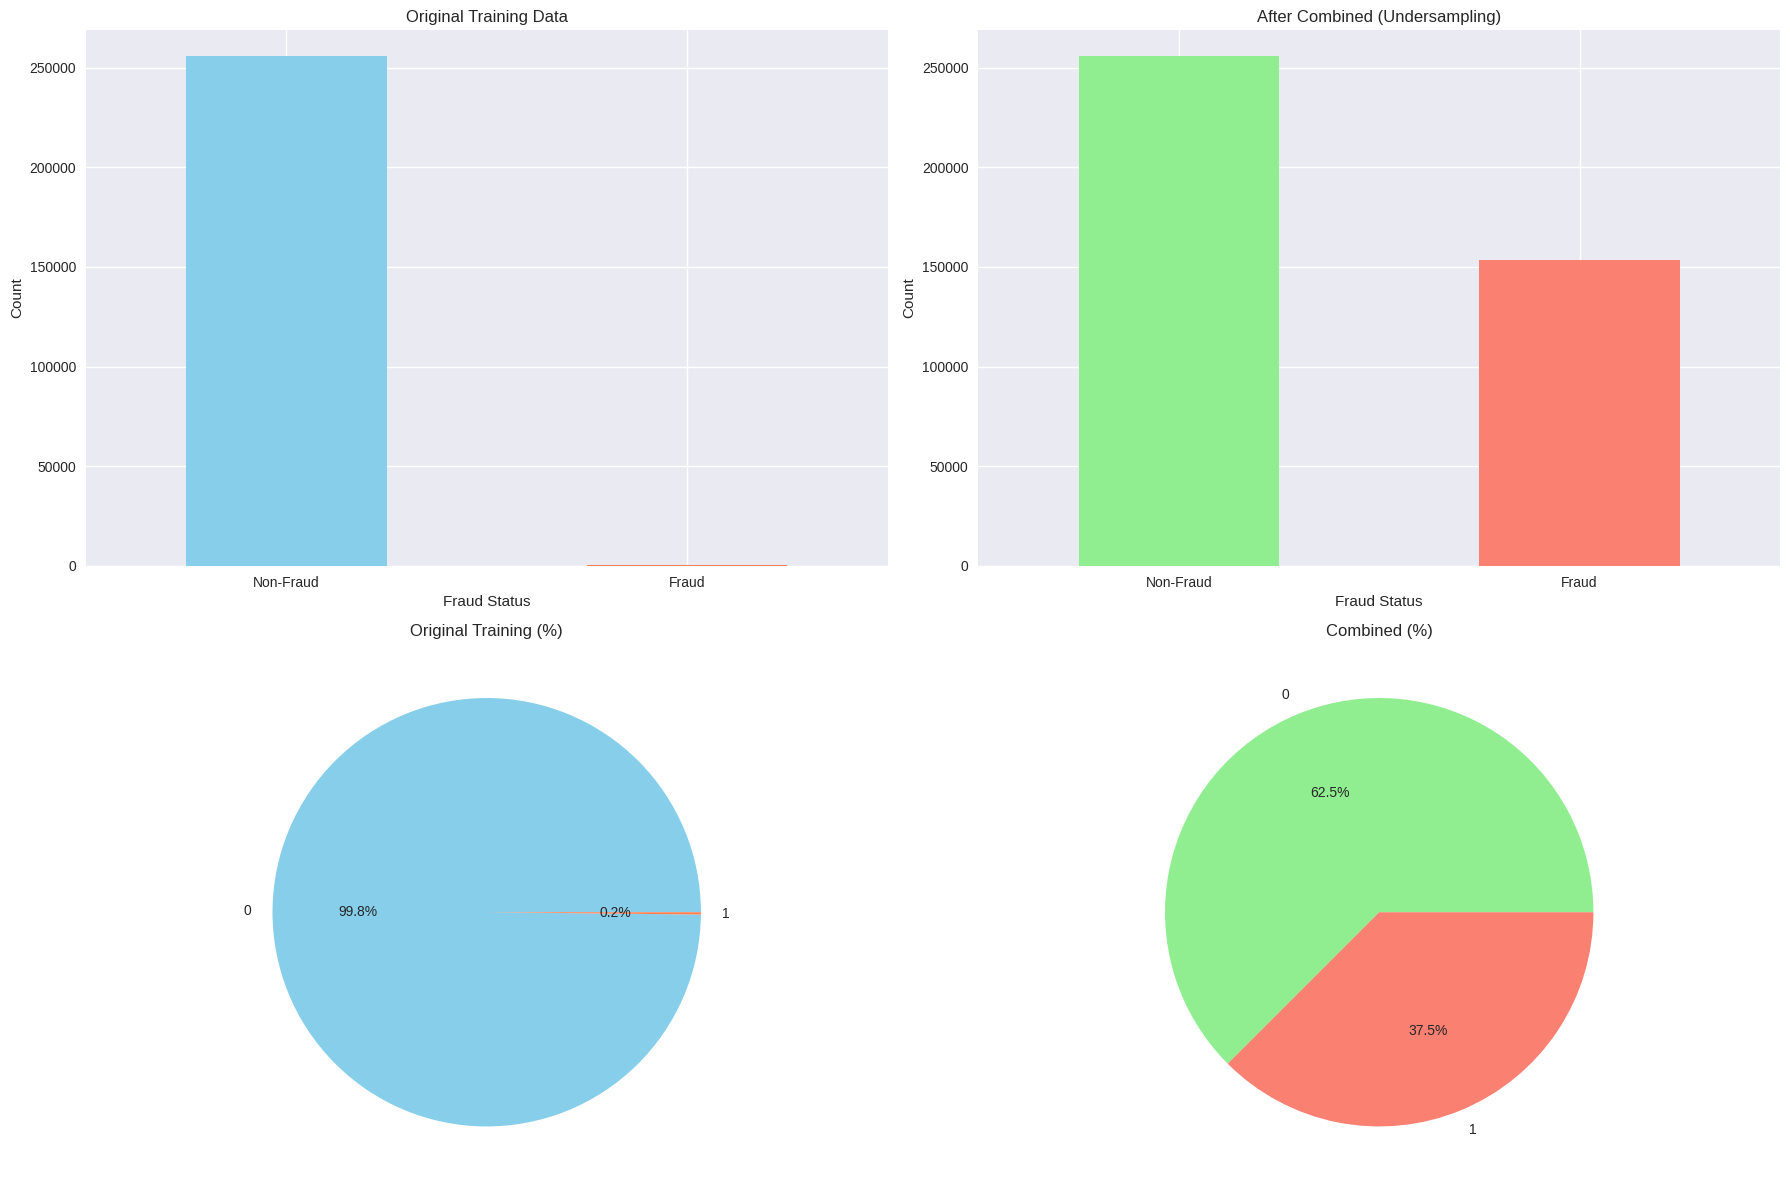

=== SAMPLING TECHNIQUES COMPARISON ===
Technique       Size       Non-Fraud  Fraud    Ratio   
-------------------------------------------------------
Original        256,326    255,883    443      577.6   :1
SMOTE           409,412    255,883    153,529  1.7     :1

🎯 Selected technique: SMOTE
📊 Test set maintained at original imbalance: 28,432 non-fraud, 49 fraud


In [ ]:
# Visualize sampling results comparison
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Original training data
y_train_raw.value_counts().plot(kind='bar', ax=axes[0, 0], color=['skyblue', 'coral'])
axes[0, 0].set_title('Original Training Data')
axes[0, 0].set_xlabel('Fraud Status')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_xticklabels(['Non-Fraud', 'Fraud'], rotation=0)

pd.Series(y_train_combined).value_counts().plot(kind='bar', ax=axes[0, 1], color=['lightgreen', 'salmon'])
axes[0, 1].set_title('After Combined (Undersampling)')
axes[0, 1].set_xlabel('Fraud Status')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_xticklabels(['Non-Fraud', 'Fraud'], rotation=0)

# Pie charts for percentages
y_train_raw.value_counts(normalize=True).plot(kind='pie', ax=axes[1, 0], autopct='%1.1f%%', colors=['skyblue', 'coral'])
axes[1, 0].set_title('Original Training (%)')
axes[1, 0].set_ylabel('')

pd.Series(y_train_combined).value_counts(normalize=True).plot(kind='pie', ax=axes[1, 1], autopct='%1.1f%%', colors=['lightgreen', 'salmon'])
axes[1, 1].set_title('Combined (%)')
axes[1, 1].set_ylabel('')

plt.tight_layout()
plt.show()

# Comparative summary
print("=== SAMPLING TECHNIQUES COMPARISON ===")
print(f"{'Technique':<15} {'Size':<10} {'Non-Fraud':<10} {'Fraud':<8} {'Ratio':<8}")
print("-" * 55)

original_fraud = (y_train_raw == 1).sum()
original_non_fraud = (y_train_raw == 0).sum()
print(f"{'Original':<15} {len(y_train_raw):<10,} {original_non_fraud:<10,} {original_fraud:<8,} {original_non_fraud/original_fraud:<8.1f}:1")

combined_fraud = (y_train_combined == 1).sum()
combined_non_fraud = (y_train_combined == 0).sum()
print(f"{selected_technique.upper():<15} {len(y_train_combined):<10,} {combined_non_fraud:<10,} {combined_fraud:<8,} {combined_non_fraud/combined_fraud:<8.1f}:1")

print(f"Test set maintained at original imbalance: {(y_test_final == 0).sum():,} non-fraud, {(y_test_final == 1).sum():,} fraud")


## 6. Data Export with Proper Train-Test Split

Saving the properly prepared datasets: training data (with selected sampling technique) and test data (original imbalanced).


In [ ]:
# Prepare final datasets for export
print("=== Preparing Final Datasets for Export ===")

# Training data: Use the selected sampling technique result
train_df_final = X_train_final.copy()
train_df_final[target_col] = y_train_final

# Test data: Use original imbalanced test set (NO SAMPLING APPLIED)
test_df_final = X_test_final.copy()
test_df_final[target_col] = y_test_final

print(f"\nFinal dataset preparation summary:")
print(f"Training set ({selected_technique}): {train_df_final.shape}")
print(f"  - Non-fraud: {(y_train_final == 0).sum():,}")
print(f"  - Fraud: {(y_train_final == 1).sum():,}")
print(f"  - Ratio: {(y_train_final == 0).sum() / (y_train_final == 1).sum():.2f}:1")

print(f"\nTest set (original imbalanced): {test_df_final.shape}")
print(f"  - Non-fraud: {(y_test_final == 0).sum():,}")
print(f"  - Fraud: {(y_test_final == 1).sum():,}")
print(f"  - Ratio: {(y_test_final == 0).sum() / (y_test_final == 1).sum():.2f}:1")

# Verify data integrity (no overlap between train/test)
print(f"\n🔍 Data Integrity Verification:")
print(f"Total samples in original dataset: {len(X_scaled_df):,}")
print(f"Total samples in train + test: {len(train_df_final) + len(test_df_final):,}")
print(f"Training samples: {len(train_df_final):,}")
print(f"Test samples: {len(test_df_final):,}")

original_test_ratio = (y_test_final == 0).sum() / (y_test_final == 1).sum()

=== Preparing Final Datasets for Export ===

Final dataset preparation summary:
Training set (smote): (409412, 31)
  - Non-fraud: 255,883
  - Fraud: 153,529
  - Ratio: 1.67:1

Test set (original imbalanced): (28481, 31)
  - Non-fraud: 28,432
  - Fraud: 49
  - Ratio: 580.24:1

🔍 Data Integrity Verification:
Total samples in original dataset: 284,807
Total samples in train + test: 437,893
Training samples: 409,412
Test samples: 28,481

✅ Test set maintains realistic imbalance ratio: 580.2:1
✅ Training set balanced with smote for better model learning


In [ ]:
# Save the properly processed datasets as CSV files
print("=== Saving Properly Processed Datasets ===")

# Save training set (with applied sampling technique)
train_df_final.to_csv(train_csv_path, index=False)
print(f"Training set saved to: {train_csv_path}")
print(f"   Shape: {train_df_final.shape}")
print(f"   Technique: {selected_technique.upper()}")

# Save test set (original imbalanced - NO SAMPLING)
test_df_final.to_csv(test_csv_path, index=False)
print(f"Test set saved to: {test_csv_path}")
print(f"   Shape: {test_df_final.shape}")
print(f"   State: Original imbalanced (realistic evaluation)")

# Verify files were saved correctly
import os
train_size = os.path.getsize(train_csv_path) / (1024*1024)  # Size in MB
test_size = os.path.getsize(test_csv_path) / (1024*1024)   # Size in MB

print(f"\nFile Verification:")
print(f"Training file size: {train_size:.2f} MB")
print(f"Test file size: {test_size:.2f} MB")

# Get final feature columns (excluding target)
target_col = class_label
final_feature_cols = [col for col in train_df_final.columns if col != target_col]

# Save comprehensive preprocessing metadata
preprocessing_metadata = {
    # Dataset information
    'original_dataset_shape': df.shape,
    'feature_columns': final_feature_cols,
    'target_column': target_col,
    
    # Preprocessing steps
    'scaling_method': scaling_method,
    'balancing_method': balancing_method,
    'train_test_split_ratio': train_test_split_ratio,
    'random_seed': random_seed,
    
    # Class distribution information
    'class_distribution_original': {
        'non_fraud': int(non_fraud_count_original),
        'fraud': int(fraud_count_original),
        'imbalance_ratio': float(imbalance_ratio_original)
    },
    # Properly separated train/test distributions
    'class_distribution_train_final': {
        'non_fraud': int((y_train_final == 0).sum()),
        'fraud': int((y_train_final == 1).sum()),
        'imbalance_ratio': float((y_train_final == 0).sum() / (y_train_final == 1).sum()),
        'sampling_technique': selected_technique
    },
    'class_distribution_test_final': {
        'non_fraud': int((y_test_final == 0).sum()),
        'fraud': int((y_test_final == 1).sum()),
        'imbalance_ratio': float((y_test_final == 0).sum() / (y_test_final == 1).sum()),
        'note': 'Original imbalanced distribution for realistic evaluation'
    },
}

# Save metadata as JSON
import json
with open(metadata_path, 'w') as f:
    json.dump(preprocessing_metadata, f, indent=2)

print(f"Preprocessing metadata saved to: {metadata_path}")

print("\n🎉 All datasets and metadata saved successfully!")


=== Saving Properly Processed Datasets ===
✅ Training set saved to: ../data/train.csv
   Shape: (409412, 31)
   Technique: SMOTE
✅ Test set saved to: ../data/test.csv
   Shape: (28481, 31)
   State: Original imbalanced (realistic evaluation)

📁 File Verification:
Training file size: 230.93 MB
Test file size: 16.17 MB
Preprocessing metadata saved to: ../data/preprocessing_metadata.json

🎉 All datasets and metadata saved successfully!
